In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sns
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
tf.random.set_seed(7)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import regularizers

In [2]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [3]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [4]:
import html
import re

# define clean function
# add / remove any line if necessary
def clean(text):
    # convert html escapes like & by their plain-text representation
    text = html.unescape(text) 
    
    # subsitute tags like  by spaces in the specified text or remove them
    text = re.sub(r'<[^<>]*>', ' ', text)
    
    # subsitute markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    
    # subsitute text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    
    # subsitute standalone sequences of specials, matches  but NOT #hashtag
    text = re.sub(r'(?:^|\s)[<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)

     # subsitute standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    
    #remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)  
    
    #remove old style retweet text "RT"
    text = re.sub(r'RT[\s]+', '', text)        
    text = re.sub(r'DT[\s]+', '', text)   
    
    #remove hashtags
    text = re.sub(r'#', '', text)
    
    return text.strip()

In [5]:
from textacy import preprocessing
from functools import partial

# create cleaning pipeline
preproc = preprocessing.make_pipeline(
    
    # join words split by a hyphen or line break
    preprocessing.normalize.hyphenated_words,
    
    # subsitute fancy quatation marks with an ASCII equivalent
    preprocessing.normalize.quotation_marks,
    
    # normalize unicode characters in text into canonical forms
    preprocessing.normalize.unicode,
    
    # remove any accents character in text by replacing them with ASCII equivalents or removing them entirely
    preprocessing.remove.accents,

    # remove all email addresses in text 
    partial(preprocessing.replace.emails, repl= ""), # or _EMAIL_
    
    # remove all phone numbers in text 
    partial(preprocessing.replace.phone_numbers, repl=""), # or _PhoneNumber_
    
    # remove all URLs in text 
    partial(preprocessing.replace.urls, repl= ""), # or _URL_
    
    # remove all (Twitter-style) user handles in text 
    partial(preprocessing.replace.user_handles, repl=""), # or _HANDLE_
    
    # Replace all hashtags in text with repl.
    #partial(preprocessing.replace.hashtags, repl="_HASTAG_"),
    
    ### TEST ### Enable it only before generating tokens for word clouds
    partial(preprocessing.replace.numbers, repl=""),
    
    # remove HTML tags from text
    preprocessing.remove.html_tags,

    # remove text within curly {}, square [], and/or round () brackets
    preprocessing.remove.brackets,

    # replace specific set of punctuation marks with whitespace
    partial(preprocessing.remove.punctuation, only=[ ",", ":", ";", "/", " ","(","@"]),
    
    # Replace all currency symbols in text with repl
    preprocessing.replace.currency_symbols,
    
    # replace all emoji and pictographs in text with repl.
    preprocessing.replace.emojis,
    
 )

In [6]:
!nvidia-smi

Fri Dec  9 15:18:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   59C    P8     6W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
train_df["text_c"] = train_df["text"].apply(clean)
train_df["text_clean"] = train_df["text_c"].apply(preproc)
train_df["text_clean"] = train_df["text_clean"].str.lower()

In [8]:
test_df["text_c"] = test_df["text"].apply(clean)
test_df["text_clean"] = test_df["text_c"].apply(preproc)
test_df["text_clean"] = test_df["text_clean"].str.lower()

In [9]:
train_df.head()

,id,keyword,location,text,target,text_c,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfires evacuation ord...",people receive wildfires evacuation orders in ...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,just got sent this photo from ruby alaska as s...


In [10]:
tweets_train = train_df["text_clean"].to_list()
tweets_test = test_df["text_clean"].to_list()
label_train = train_df["target"].to_list()

In [38]:
length = 0
for i in (tweets_test):
    if length < len(i):
        length = len(i)
print(length)

149


In [31]:
# from transformers import AutoTokenizer

In [32]:
# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast = True, normalization = True)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
input_ids = []

In [12]:
num_words = 10000
tokenizer = Tokenizer(num_words=10000, oov_token="unk")
tokenizer.fit_on_texts(tweets_train)

In [13]:
print(str(tokenizer.texts_to_sequences(["I'm vraj patel"])))

[[42, 1, 1]]


In [14]:
y_train_df = train_df["target"].to_list()
# print(y_train)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(tweets_train, y_train_df, test_size=0.2, random_state=52)

In [16]:
X_train = np.array(tokenizer.texts_to_sequences(tweets_train))
X_train = pad_sequences(X_train, padding="post", maxlen= 160)
# x_val = np.array(tokenizer.texts_to_sequences(x_val))
# x_val = pad_sequences(x_val, padding="post", maxlen=160)
Y_train = np.asarray(y_train_df)
# y_val = np.asarray(y_val)
x_test = np.array(tokenizer.texts_to_sequences(tweets_test))
x_test = pad_sequences(x_test, padding="post",maxlen=160)

C:\Users\vrajp\AppData\Local\Temp\ipykernel_13828\407305780.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array(tokenizer.texts_to_sequences(tweets_train))
C:\Users\vrajp\AppData\Local\Temp\ipykernel_13828\407305780.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test = np.array(tokenizer.texts_to_sequences(tweets_test))


In [17]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=52)

In [18]:
train_Dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
val_Dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val))

In [19]:
max_features = 15000
embedding_dim = 64
sequence_length = 160

In [20]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features+1, embedding_dim, input_length=sequence_length, embeddings_regularizer=regularizers.l2(0.005)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(embedding_dim, dropout=0.2, activation="tanh", recurrent_activation="sigmoid",
                                recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), 
                                bias_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(8,activation="relu", kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))


In [21]:
metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives(),tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(0.001), metrics=(metrics))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 160, 64)           960064    
                                                                 
 dropout (Dropout)           (None, 160, 64)           0         
                                                                 
 lstm (LSTM)                 (None, 160, 64)           33024     
                                                                 
 flatten (Flatten)           (None, 10240)             0         
                                                                 
 dense (Dense)               (None, 512)               5243392   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4

In [22]:
tf.keras.utils.plot_model(model, "mult_input_and_output_model.png", show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
epochs = 10
history = model.fit((train_Dataset.shuffle(6090)).batch(32),
                    epochs= epochs,
                    validation_data=val_Dataset.shuffle(1522).batch(32),
                    verbose=1)

Epoch 1/10
191/191 [==============================] - 24s 115ms/step - loss: 1.0838 - binary_accuracy: 0.5632 - false_negatives: 2582.0000 - false_positives: 78.0000 - precision: 0.4730 - recall: 0.0264 - val_loss: 0.7404 - val_binary_accuracy: 0.5936 - val_false_negatives: 619.0000 - val_false_positives: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
191/191 [==============================] - 21s 113ms/step - loss: 0.7365 - binary_accuracy: 0.5645 - false_negatives: 2652.0000 - false_positives: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7145 - val_binary_accuracy: 0.5936 - val_false_negatives: 619.0000 - val_false_positives: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
191/191 [==============================] - 22s 115ms/step - loss: 0.7222 - binary_accuracy: 0.6036 - false_negatives: 2207.0000 - false_positives: 207.0000 - precision: 0.6825 - recall: 0.1678 - val_loss: 0.6552 - val_binary_accuracy: 0

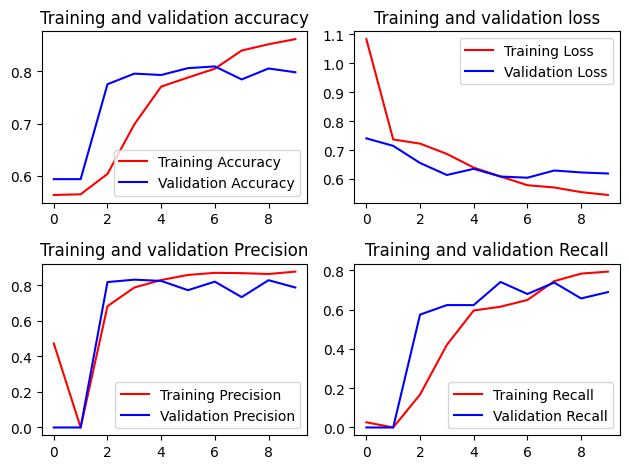

In [25]:
#plot with val and train accuracy
#plot with train loss and val loss
#plot with train precision and val precision
#plot with train recall and val recall
accuracy = history.history["binary_accuracy"]
val_accuracy = history.history["val_binary_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
precision = history.history["precision"]
val_precision = history.history["val_precision"]
recall = history.history["recall"]
val_recall = history.history["val_recall"]
epochs = range(len(accuracy))

fig, axs = plt.subplots(2,2)

axs[0,0].plot(epochs, accuracy, "r", label="Training Accuracy")
axs[0,0].plot(epochs, val_accuracy, "b", label="Validation Accuracy")
axs[0,0].set_title("Training and validation accuracy")
axs[0,0].legend()
# plt.figure()
axs[0,1].plot(epochs, loss, "r", label="Training Loss")
axs[0,1].plot(epochs, val_loss, "b", label="Validation Loss")
axs[0,1].set_title("Training and validation loss")
axs[0,1].legend()

axs[1,0].plot(epochs, precision, "r", label="Training Precision")
axs[1,0].plot(epochs, val_precision, "b", label="Validation Precision")
axs[1,0].set_title("Training and validation Precision")
axs[1,0].legend()

axs[1,1].plot(epochs, recall, "r", label="Training Recall")
axs[1,1].plot(epochs, val_recall, "b", label="Validation Recall")
axs[1,1].set_title("Training and validation Recall")
axs[1,1].legend()

fig.tight_layout()
# plt.show()

In [26]:
test_Dataset = tf.data.Dataset.from_tensor_slices(x_test)

In [38]:
y_test = model.predict(x_test)

102/102 [==============================] - 2s 24ms/step


In [39]:
y_test

array([[0.77730376],
       [0.6467557 ],
       [0.83368295],
       ...,
       [0.8351181 ],
       [0.67700934],
       [0.362841  ]], dtype=float32)

In [50]:
y_results = []
for i in range(y_test.shape[0]):
    if y_test[i,:] >= 0.45:
        y_results.append(1)
    else:
        y_results.append(0)

In [51]:
y_results

[1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,


In [58]:
ids = test_df["id"]
predictions = pd.DataFrame(y_results,columns=['target'])
results = pd.merge(ids, predictions, left_index=True,right_index=True)

In [59]:
results

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [53]:
results.to_csv("res_optih_acc_nothreshopti.csv", sep = ",", index = False)

In [54]:
results.to_csv('D:/Fall 2022/ECSE 526/Project/results_labels.csv')



In [46]:
results

,id,target
0,0,0.777304
1,2,0.646756
2,3,0.833683
3,9,0.426565
4,11,0.969616
...,...,...
3258,10861,0.721336
3259,10865,0.898987
3260,10868,0.835118
3261,10874,0.677009


In [42]:
!kaggle competitions submit -c nlp-getting-started -f res.csv

Traceback (most recent call last):
  File "C:\Users\vrajp\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\vrajp\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\vrajp\python_stuff\venvs\vraj_env\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "C:\Users\vrajp\python_stuff\venvs\vraj_env\lib\site-packages\kaggle\__init__.py", line 23, in <module>
    api.authenticate()
  File "C:\Users\vrajp\python_stuff\venvs\vraj_env\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in C:\Users\vrajp\.kaggle. Or use the environment method.


In [64]:
epochs = 5
history_2 = model.fit((train_Dataset.shuffle(6090)).batch(64),
                    epochs= epochs,
                    validation_data=val_Dataset.shuffle(1522).batch(64),
                    verbose=1)

Epoch 1/5
96/96 [==============================] - 21s 223ms/step - loss: 0.4769 - binary_accuracy: 0.8767 - false_negatives_2: 532.0000 - false_positives_2: 219.0000 - precision_3: 0.9064 - recall_2: 0.7994 - val_loss: 0.6296 - val_binary_accuracy: 0.8017 - val_false_negatives_2: 174.0000 - val_false_positives_2: 128.0000 - val_precision_3: 0.7766 - val_recall_2: 0.7189
Epoch 2/5
96/96 [==============================] - 21s 220ms/step - loss: 0.4532 - binary_accuracy: 0.8829 - false_negatives_2: 505.0000 - false_positives_2: 208.0000 - precision_3: 0.9117 - recall_2: 0.8096 - val_loss: 0.6573 - val_binary_accuracy: 0.7978 - val_false_negatives_2: 159.0000 - val_false_positives_2: 149.0000 - val_precision_3: 0.7553 - val_recall_2: 0.7431
Epoch 3/5
96/96 [==============================] - 22s 224ms/step - loss: 0.4386 - binary_accuracy: 0.8865 - false_negatives_2: 491.0000 - false_positives_2: 200.0000 - precision_3: 0.9153 - recall_2: 0.8149 - val_loss: 0.6897 - val_binary_accuracy: 0.

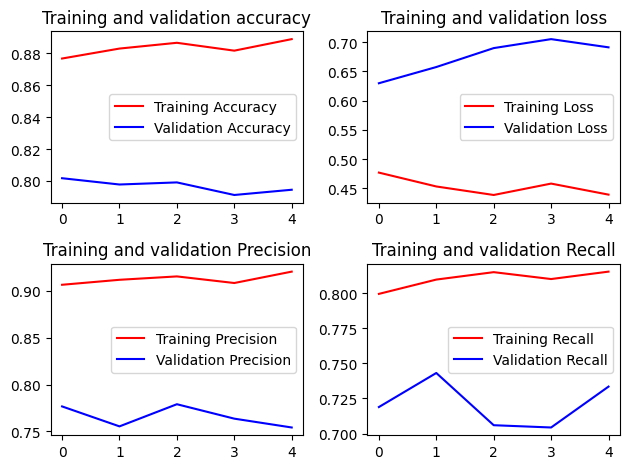

In [77]:
accuracy = history_2.history["binary_accuracy"]
val_accuracy = history_2.history["val_binary_accuracy"]
loss = history_2.history["loss"]
val_loss = history_2.history["val_loss"]
precision = history_2.history["precision_3"]
val_precision = history_2.history["val_precision_3"]
recall = history_2.history["recall_2"]
val_recall = history_2.history["val_recall_2"]
epochs = range(len(accuracy))

fig, axs = plt.subplots(2,2)

axs[0,0].plot(epochs, accuracy, "r", label="Training Accuracy")
axs[0,0].plot(epochs, val_accuracy, "b", label="Validation Accuracy")
axs[0,0].set_title("Training and validation accuracy")
axs[0,0].legend()
# plt.figure()
axs[0,1].plot(epochs, loss, "r", label="Training Loss")
axs[0,1].plot(epochs, val_loss, "b", label="Validation Loss")
axs[0,1].set_title("Training and validation loss")
axs[0,1].legend()

axs[1,0].plot(epochs, precision, "r", label="Training Precision")
axs[1,0].plot(epochs, val_precision, "b", label="Validation Precision")
axs[1,0].set_title("Training and validation Precision")
axs[1,0].legend()

axs[1,1].plot(epochs, recall, "r", label="Training Recall")
axs[1,1].plot(epochs, val_recall, "b", label="Validation Recall")
axs[1,1].set_title("Training and validation Recall")
axs[1,1].legend()

fig.tight_layout()

In [65]:
epochs = 5
history_1 = model.fit((train_Dataset.shuffle(6090)).batch(16),
                    epochs= epochs,
                    validation_data=val_Dataset.shuffle(1522).batch(16),
                    verbose=1)

Epoch 1/5
381/381 [==============================] - 42s 111ms/step - loss: 0.6095 - binary_accuracy: 0.8299 - false_negatives_2: 727.0000 - false_positives_2: 309.0000 - precision_3: 0.8617 - recall_2: 0.7259 - val_loss: 0.6612 - val_binary_accuracy: 0.7978 - val_false_negatives_2: 177.0000 - val_false_positives_2: 131.0000 - val_precision_3: 0.7714 - val_recall_2: 0.7141
Epoch 2/5
381/381 [==============================] - 39s 102ms/step - loss: 0.5741 - binary_accuracy: 0.8409 - false_negatives_2: 657.0000 - false_positives_2: 312.0000 - precision_3: 0.8648 - recall_2: 0.7523 - val_loss: 0.6631 - val_binary_accuracy: 0.7925 - val_false_negatives_2: 247.0000 - val_false_positives_2: 69.0000 - val_precision_3: 0.8435 - val_recall_2: 0.6010
Epoch 3/5
381/381 [==============================] - 38s 100ms/step - loss: 0.5631 - binary_accuracy: 0.8388 - false_negatives_2: 679.0000 - false_positives_2: 303.0000 - precision_3: 0.8669 - recall_2: 0.7440 - val_loss: 0.6325 - val_binary_accurac

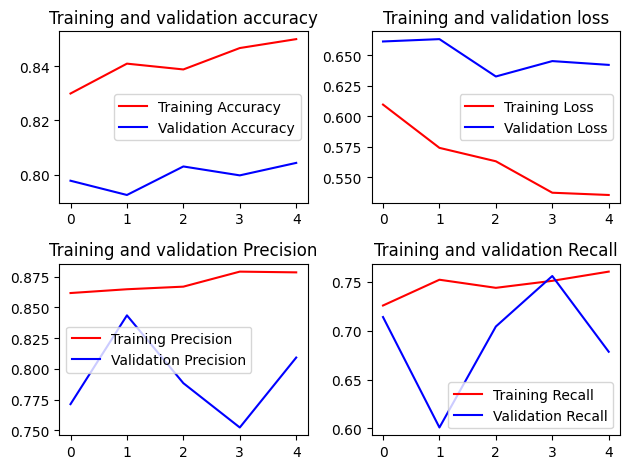

In [78]:
accuracy = history_1.history["binary_accuracy"]
val_accuracy = history_1.history["val_binary_accuracy"]
loss = history_1.history["loss"]
val_loss = history_1.history["val_loss"]
precision = history_1.history["precision_3"]
val_precision = history_1.history["val_precision_3"]
recall = history_1.history["recall_2"]
val_recall = history_1.history["val_recall_2"]
epochs = range(len(accuracy))

fig, axs = plt.subplots(2,2)

axs[0,0].plot(epochs, accuracy, "r", label="Training Accuracy")
axs[0,0].plot(epochs, val_accuracy, "b", label="Validation Accuracy")
axs[0,0].set_title("Training and validation accuracy")
axs[0,0].legend()
# plt.figure()
axs[0,1].plot(epochs, loss, "r", label="Training Loss")
axs[0,1].plot(epochs, val_loss, "b", label="Validation Loss")
axs[0,1].set_title("Training and validation loss")
axs[0,1].legend()

axs[1,0].plot(epochs, precision, "r", label="Training Precision")
axs[1,0].plot(epochs, val_precision, "b", label="Validation Precision")
axs[1,0].set_title("Training and validation Precision")
axs[1,0].legend()

axs[1,1].plot(epochs, recall, "r", label="Training Recall")
axs[1,1].plot(epochs, val_recall, "b", label="Validation Recall")
axs[1,1].set_title("Training and validation Recall")
axs[1,1].legend()

fig.tight_layout()

In [45]:
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Embedding(max_features+1, embedding_dim, input_length=sequence_length, embeddings_regularizer=regularizers.l2(0.005)))
model_1.add(tf.keras.layers.Dropout(0.4))
model_1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.2, activation="tanh", recurrent_activation="sigmoid",
                                recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), 
                                bias_regularizer=regularizers.l2(0.001))))
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(512, activation="relu"))
model_1.add(tf.keras.layers.Dropout(0.4))
model_1.add(tf.keras.layers.Dense(8,activation="relu", kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model_1.add(tf.keras.layers.Dropout(0.4))
model_1.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model_1.summary()
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(0.0015), metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 160, 64)           960064    
                                                                 
 dropout_15 (Dropout)        (None, 160, 64)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 160, 128)         66048     
 nal)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 20480)             0         
                                                                 
 dense_15 (Dense)            (None, 512)               10486272  
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                      

In [ ]:
epochs = 5
history_1 = model.fit((train_Dataset.shuffle(6090)).batch(16),
                    epochs= epochs,
                    validation_data=val_Dataset.shuffle(1522).batch(16),
                    verbose=1)

In [27]:
import optuna 


In [47]:
def make_confusion_heatmap(
    cf,
    group_names = None,
    categories = "auto",
    count = True,
    percent = True,
    cbar = True,
    xyticks = True,
    xyplotlabels = True,
    sum_stats = True,
    figsize = None,
    cmap = "Blues",
    title = None
):
    blanks = ["" for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    
    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]

    else:
        group_percentages = blanks

    box_labels = [
        f"{v1}{v2}{v3}".strip()
        for v1,v2,v3 in zip(group_labels, group_counts, group_percentages)
    ]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    if sum_stats:
        accuracy = np.trace(cf)/float(np.sum(cf))

        if len(cf) == 2:
            precision = cf[1,1]/ sum(cf[:,1])
            recall = cf[1,1]/ sum (cf[1,:])
            f1_score = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy = {:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score
            )
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    if figsize == None:
        figsize = plt.rcParams.get("figure.figsize")

    if xyticks == False:
        categories = False

    plt.figure(figsize=figsize)
    sns.heatmap(
        cf,
        annot=box_labels,
        fmt='',
        cmap = cmap,
        cbar = cbar,
        xticklabels=categories,
        yticklabels=categories,
    )
    if xyplotlabels:
        plt.ylabel("True Label")
        plt.xlabel("Predicted label" + stats_text)
    else:
        plt.xlabel(stats_text)
    if title:
        plt.title(title)

In [40]:
from sklearn.metrics import confusion_matrix

def get_preds(dataloader, model, thresold = 0.5):
    all_labels = tf.Tensor([])
    all_preds = tf.Tensor([])

    

In [44]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features+1, embedding_dim, input_length=sequence_length, embeddings_regularizer=regularizers.l2(0.005)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.2, activation="tanh", recurrent_activation="sigmoid",
                                recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), 
                                bias_regularizer=regularizers.l2(0.001))))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(8,activation="relu", kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

In [50]:
def create_model(trial):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(max_features+1, embedding_dim, input_length=sequence_length, embeddings_regularizer=regularizers.l2(0.005)))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.LSTM(embedding_dim, dropout = 0.2, activation ="tanh", recurrent_activation="sigmoid",
                                            recurrent_dropout = 0.2, return_sequences=True, kernel_regularizer = regularizers.l2(0.001),
                                            bias_regularizer=regularizers.l2(0.001)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation="relu"))
    model.add(tf.keras.layers.Dropout((0.4)))
    model.add(tf.keras.layers.Dense(8,activation="relu", kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1,activation="sigmoid"))
    # model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

In [66]:
def create_optimizer(trial):
    kwargs = {}
    optimizer_options = ["Adam"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-3, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-3, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer


In [62]:
def learn(model, optimizer, dataset, mode="eval"):
    accuracy = tf.metrics.Accuracy("accuracy", dtype=tf.float32)

    for batch, (tweet, labels) in enumerate(dataset):
        with tf.GradientTape() as tape:
            logits = model(tweet, training=(mode == "train"))
            loss_value = tf.keras.losses.BinaryCrossentropy()(labels, logits)
            
            if mode == "eval":
                accuracy(
                    tf.argmax(logits, axis=1, output_type=tf.int64), tf.cast(labels, tf.int64)
                )
            else:
                grads = tape.gradient(loss_value, model.variables)
                optimizer.apply_gradients(zip(grads, model.variables))

    if mode == "eval":
        return accuracy

In [63]:
epochs = 5

In [68]:
def objective(trial):
    model = create_model(trial)
    optimizer = create_optimizer(trial)
    with tf.device("/cpu:0"):
        for _ in range(epochs):
            learn(model, optimizer, train_Dataset.batch(32), "train")

        accuracy = learn(model, optimizer, val_Dataset.batch(32), "eval")

    return accuracy.result()

In [69]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 10)
print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial
print(" Value: ", trial.value)
print("  Params: ")
for key, values in trial.params.items():
    print("  {}: {}".format(key,values))

[I 2022-12-08 13:13:36,671] A new study created in memory with name: no-name-22d18d3b-ad8b-4611-b3de-7d0820f94f5d


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "c:\Users\vrajp\python_stuff\venvs\vraj_env\lib\site-packages\keras\backend.py", line 5129, in <genexpr>
    output_ta_t = tuple(  File "c:\Users\vrajp\python_stuff\venvs\vraj_env\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


[I 2022-12-08 13:56:13,984] Trial 0 finished with value: 0.5935653448104858 and parameters: {'optimizer': 'Adam', 'adam_learning_rate': 0.09199408748846169}. Best is trial 0 with value: 0.5935653448104858.
[I 2022-12-08 14:48:23,793] Trial 1 finished with value: 0.5935653448104858 and parameters: {'optimizer': 'Adam', 'adam_learning_rate': 0.003053452616396742}. Best is trial 0 with value: 0.5935653448104858.
[I 2022-12-08 15:55:49,372] Trial 2 finished with value: 0.5935653448104858 and parameters: {'optimizer': 'Adam', 'adam_learning_rate': 0.021161930185010776}. Best is trial 0 with value: 0.5935653448104858.
[I 2022-12-08 17:17:44,930] Trial 3 finished with value: 0.5935653448104858 and parameters: {'optimizer': 'Adam', 'adam_learning_rate': 0.03548970177624462}. Best is trial 0 with value: 0.5935653448104858.
[I 2022-12-08 18:56:57,217] Trial 4 finished with value: 0.5935653448104858 and parameters: {'optimizer': 'Adam', 'adam_learning_rate': 0.0016452435632030979}. Best is trial 

KeyboardInterrupt: 

In [70]:
lr = 0.5935653448104858